In [ ]:
pip install -q tfds-nightly tensorflow matplotlib

     |████████████████████████████████| 4.0 MB 6.5 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds
import PIL
from PIL import Image

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K

class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [ ]:
model = MiniVGGNet.build(width=125, height=125, depth=3, classes=3)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 125, 125, 32)      896       
_________________________________________________________________
activation_24 (Activation)   (None, 125, 125, 32)      0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 125, 125, 32)      128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_25 (Activation)   (None, 125, 125, 32)      0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 125, 125, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 32)       

In [ ]:
datasets, info = tfds.load('beans', with_info=True, as_supervised=True)
beans_train, beans_test = datasets['train'], datasets['test']

print(info)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [ ]:
%%capture
!pip install wandb

In [ ]:
!wandb login

wandb: Currently logged in as: lucas208 (use `wandb login --relogin` to force relogin)


In [ ]:
import matplotlib

# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import numpy as np
import wandb
from wandb.keras import WandbCallback

def resize(image, label):
    return tf.image.resize(image, (125,125)), label

beans_train = beans_train.map(resize)
beans_test = beans_test.map(resize)

train_x = list(map(lambda x: x[0], beans_train))
train_y = list(map(lambda x: x[1], beans_train))

test_x = list(map(lambda x: x[0], beans_test))
test_y = list(map(lambda x: x[1], beans_test))

train_x = np.array(train_x) 
train_y = np.array(train_y)

test_x = np.array(test_x) 
test_y = np.array(test_y)

train_x = train_x.astype("float") / 255.0
test_x = test_x.astype("float") / 255.0

lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

labelNames = ["angular_leaf_spot", "bean_rust", "healthy"]

print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(1034, 125, 125, 3)
(128, 125, 125, 3)
(1034, 3)
(128, 3)


In [ ]:
# Set an experiment name to group training and evaluation
experiment_name = wandb.util.generate_id()

# setup wandb
wandb.init(project="beans_VGG", 
           group=experiment_name,
           config={
               "epoch": 40,
               "batch_size": 64,
           })
config = wandb.config

In [ ]:
%%wandb

# initialize the optimizer and model
print("[INFO] compiling model...")

# An decay parameter was used. This argument is used to slowly reduce the learning rate over time.
# Rate Schedulers, decaying the learning rate is helpful in reducing overfitting
# and obtaining higher classification accuracy – the smaller the learning rate is, 
# the smaller the weight updates will be. A common setting for decay is to divide
# the initial learning rate by the total number of epochs – in this case, 
# we’ll be training our network for a total of 40 epochs with an initial learning rate of 0.01,
# therefore decay = 0.01 / 40.

opt = SGD(learning_rate=0.01, decay=0.01/40, momentum=0.9, nesterov=True)
model = MiniVGGNet.build(width=125, height=125, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(train_x, train_y, validation_data=(test_x, test_y),
              batch_size=config.batch_size, 
              epochs=config.epoch,
              verbose=1,
              callbacks=[WandbCallback()])
wandb.finish()

[INFO] compiling model...
[INFO] training network...
Epoch 1/40
17/17 [==============================] - 83s 5s/step - loss: 1.5291 - accuracy: 0.5619 - val_loss: 2.5656 - val_accuracy: 0.3359
Epoch 2/40
17/17 [==============================] - 83s 5s/step - loss: 0.7456 - accuracy: 0.7157 - val_loss: 3.2197 - val_accuracy: 0.3438
Epoch 3/40
17/17 [==============================] - 82s 5s/step - loss: 0.5154 - accuracy: 0.7921 - val_loss: 2.5632 - val_accuracy: 0.3438
Epoch 4/40
17/17 [==============================] - 84s 5s/step - loss: 0.4668 - accuracy: 0.8250 - val_loss: 1.7940 - val_accuracy: 0.5000
Epoch 5/40
17/17 [==============================] - 82s 5s/step - loss: 0.3236 - accuracy: 0.8743 - val_loss: 4.7222 - val_accuracy: 0.3516
Epoch 6/40
17/17 [==============================] - 81s 5s/step - loss: 0.3139 - accuracy: 0.8791 - val_loss: 3.1677 - val_accuracy: 0.5703
Epoch 7/40
17/17 [==============================] - 80s 5s/step - loss: 0.2858 - accuracy: 0.8888 - val_los

epoch,39
loss,0.02797
accuracy,0.99226
val_loss,1.19867
val_accuracy,0.78125
_runtime,3312
_timestamp,1631400294
_step,39
best_val_loss,0.96009
best_epoch,18


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▆▆▇▇▇█▇▇▇████████▇▇▇██████████████
val_loss,▃▃▃▂▅▃█▇▆▄▇▅▅▄▂▂▂▁▁▂▂▂▄▂▇▄▃▂▁▁▁▁▁▂▁▁▁▂▁▁
val_accuracy,▁▁▁▃▁▅▁▁▂▃▁▂▃▂▆▅▆▇▇▆▆▆▄▆▂▃▅▆▇▇▆▆▇▆▇█████
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [ ]:
%%capture
# Install dependencies
!pip install scikit-plot -qqq

_runtime,9
_timestamp,1631400612
_step,1
f1,0.78125


_runtime,▁█
_timestamp,▁█
_step,▁█
f1,▁


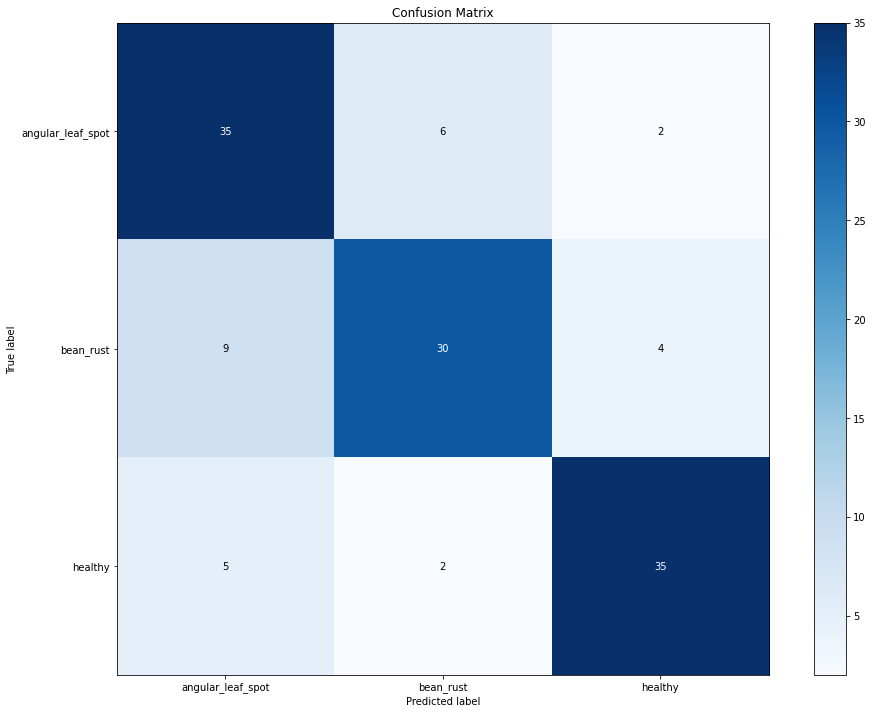

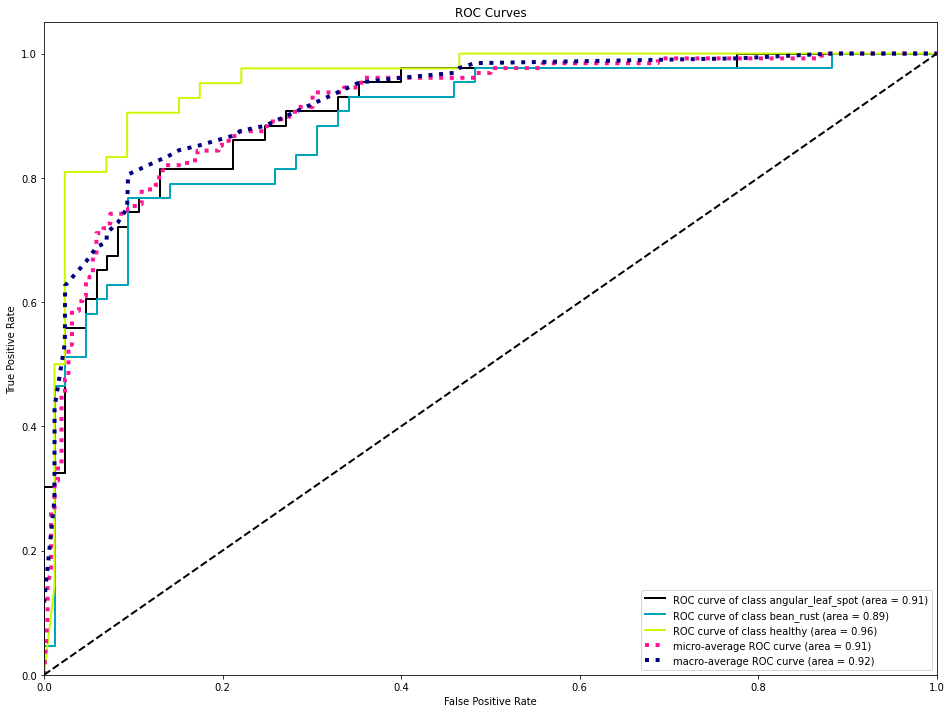

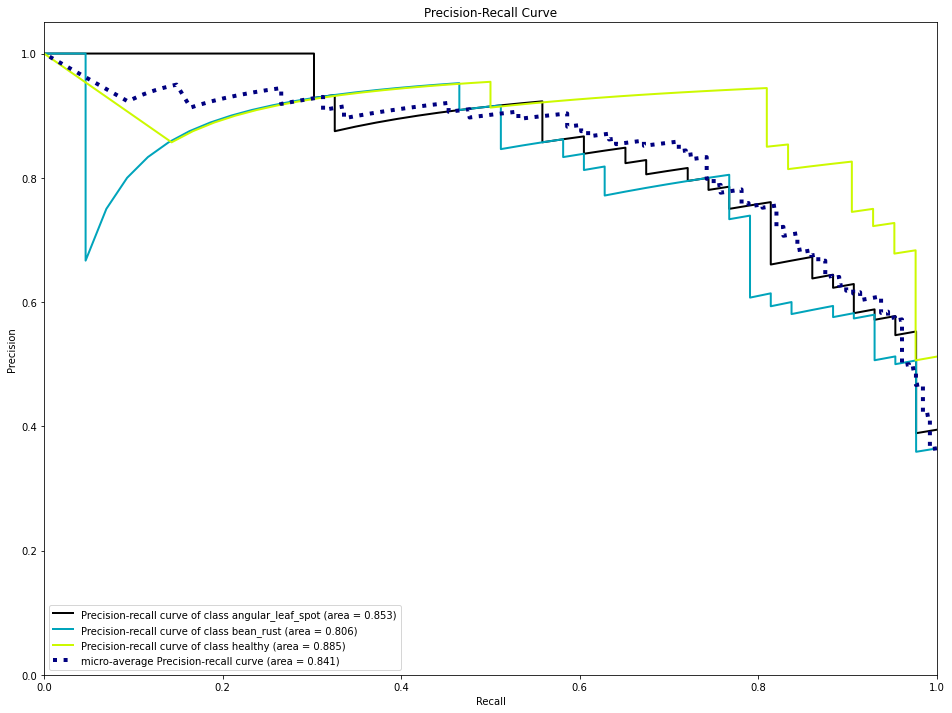

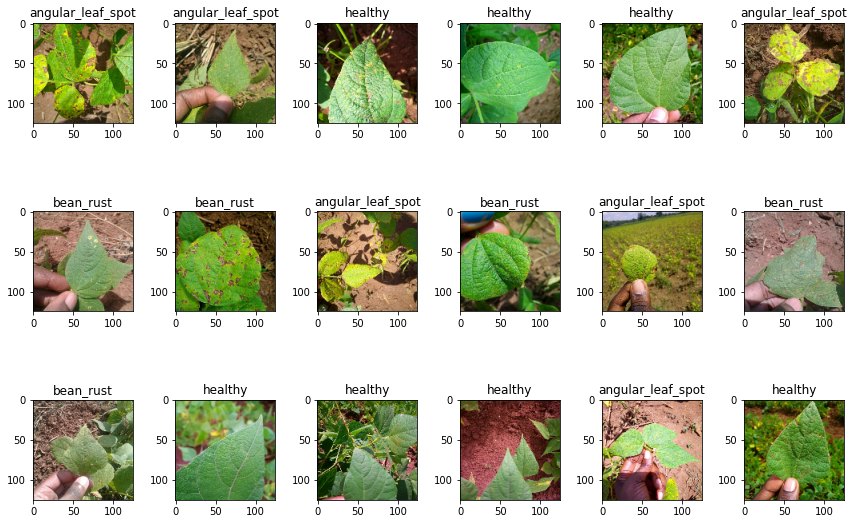

In [ ]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import tensorflow as tf
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall

wandb.init(project="beans_VGG", group=experiment_name)

# Class proportions
train_y_labels = [labelNames[i] for i in np.argmax(train_y, axis=1)]
test_y_labels = [labelNames[i] for i in np.argmax(test_y, axis=1)]
wandb.log({'Class Proportions': wandb.sklearn.plot_class_proportions(train_y_labels,
                                                                     test_y_labels,
                                                                     labelNames)},
           commit=False) # Hold on, more incoming!

# Log F1 Score
test_y_pred = np.asarray(model.predict(test_x))
test_y_pred_class = np.argmax(test_y_pred, axis=1)
f1 = f1_score(np.argmax(test_y, axis=1), test_y_pred_class, average='micro')
wandb.log({"f1": f1}, commit=False)

#test_y_labels = [labelNames[i] for i in np.argmax(test_y, axis=1)]
test_y_pred_labels = [labelNames[i] for i in test_y_pred_class]


# Log Confusion Matrix
fig, ax = plt.subplots(figsize=(16, 12))
plot_confusion_matrix(test_y_labels, test_y_pred_labels, ax=ax)
wandb.log({"confusion_matrix": wandb.Image(fig)}, commit=False)

# Log ROC Curve
fig, ax = plt.subplots(figsize=(16, 12))
plot_roc(test_y_labels, test_y_pred, ax=ax)
wandb.log({"plot_roc": wandb.Image(fig)},commit=False)  # Now we've logged everything for this step

# Precision vs Recall
fig, ax = plt.subplots(figsize=(16, 12))
plot_precision_recall(test_y_labels, test_y_pred, ax=ax)
wandb.log({"plot_precision_recall": wandb.Image(fig)},commit=False)  # Now we've logged everything for this step

# Class Scores
class_score_data = []
for test, pred in zip(test_y_labels, test_y_pred):
    class_score_data.append([test, pred])

wandb.log({"class_scores": wandb.Table(data=class_score_data,
                                           columns=["test", "pred"])}, commit=False)

# 
# Visualize Predictions
# 
# visualize 18 images
def show_image(train_image, label, index):
    plt.subplot(3, 6, index+1)
    plt.imshow(tf.squeeze(train_image), cmap=plt.cm.gray)
    plt.title(label)
    plt.grid(b=False)

# predictions
predictions = model.predict(test_x)
results = np.argmax(predictions, axis = 1)

# visualize the first 18 test results
plt.figure(figsize=(12, 8))
for index in range(18):
    label = results[index]
    image_pixels = test_x[index,:,:,:]
    show_image(image_pixels, labelNames[label], index)
plt.tight_layout()

wandb.log({"Predictions": plt}, commit=True)

wandb.finish()

In [ ]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(test_x, batch_size=64)
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
                   precision    recall  f1-score   support

angular_leaf_spot       0.71      0.81      0.76        43
        bean_rust       0.79      0.70      0.74        43
          healthy       0.85      0.83      0.84        42

         accuracy                           0.78       128
        macro avg       0.79      0.78      0.78       128
     weighted avg       0.79      0.78      0.78       128

